In [1]:
import pandas as pd
import numpy as np # library to handle data in a vectorized manner
import geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude value
import folium # map rendering library
import re
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
# Importing some classifiers methods
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
# Metrics for classification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


In [2]:
#! pip install statsmodels --user
from statsmodels.stats.outliers_influence import variance_inflation_factor 
def variance_influence_factors(X,columns,vif_treshold):
        "Analysis of variance influence factors or colinearity"
        vif = pd.DataFrame()
        vif["features"] =columns
        X_vif=np.asarray(X[:,:])
        vif_list=[]
        for i in range(X_vif.shape[1]):
            try:
                vf=variance_inflation_factor(X_vif, i)
            except:
                vf=100.00
            vif_list.append(vf)    
        vif["VIF Factor"]=vif_list
        vif=np.asarray(vif)
        vif =dict(vif)
        vif_inverse={}
        for key,value in vif.items():
            vif_inverse[value]=key
        keys_ordered=[vif_inverse[name] for name in sorted(vif.values(),reverse=True)]
        vif_ordered=pd.DataFrame(index=keys_ordered,columns=['VIF Factor'])

        for key in keys_ordered:
            vif_ordered.loc[key,:]=vif[key]

         
        key_colinearity= vif_ordered.index[np.where(vif_ordered.iloc[:,0]>vif_treshold)]
        key_colinearity=list(set(key_colinearity))
        return vif_ordered,print("\n","The following features are collinears: "\
                     + ','.join(key for key in key_colinearity),"\n",sep="\n")

In [3]:
boroughs=pd.read_csv("/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/DATA/Boroughs_london.csv",index_col=0)

In [4]:
neighbourhoods=pd.read_csv('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/DATA/neighbourhoods_london.csv',index_col=0)

In [5]:
London_neig_grouped_mean=pd.read_csv('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/DATA/london_neig_grouped_CATEGORY_mean.csv',index_col=0)

In [6]:
columns=London_neig_grouped_mean.columns[1:]

In [7]:
London_neig_grouped_mean['Favourite']=np.zeros(len(London_neig_grouped_mean.index)).astype(int)

In [8]:
places=[]
patterns=['https']
with open ("/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/DATA/Most_visited_london.txt",'r') as f:
    line=f.readlines()
    for place in line:
        for pattern in patterns:
            if re.search(pattern, place):
                pass
            else:
                places.append(place.split('\n')[0].strip())
        
        

In [9]:
with open ("/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/DATA/Other_visited_places.txt",'r') as f:
    line=f.readlines()
    for place in line:
           places.append(place.split('\n')[0].strip())         

In [10]:
print(places)

['Southbank', 'Bermondsey', 'Camden', 'Notting Hill', 'Peckham', 'Whitechapel', 'Kings Cross', 'Fitzrovia', 'Covent Garden', 'Elephant and Castle', 'City of London', 'Richmond', 'Greenwich', 'Shoreditch', 'Westminster', 'Mayfair', 'Shoreditch', 'Chelsea', 'Greenwich', 'Southwark', 'Brixton', 'Notting Hill', 'Camden', 'Soho', 'Kensington', 'City of London', 'Barnet', 'Camden', 'Hammersmith and Fulham', 'Kensington and Chelsea', 'Lambeth', 'Southwark', 'Westminster']


In [11]:
places=list(set(places))

In [12]:
place_not_neig=[]
for place in places:
    if place not in London_neig_grouped_mean['Neighbourhood'].values:
        place_not_neig.append(place)

In [13]:
place_not_neig=list(set(place_not_neig))
place_not_neig

['Barnet',
 'Camden',
 'City of London',
 'Kensington and Chelsea',
 'Hammersmith and Fulham',
 'Southwark']

In [14]:
place_neig=[x for x in places if x not in place_not_neig]

In [15]:
for place in place_not_neig:
    neig_list=neighbourhoods.loc[neighbourhoods.loc[:,'Borough'].values==place]['Neighbourhood'].values
    for neig in neig_list:
        place_neig.append(neig)


In [16]:
place_neig=list(set(place_neig))
len(place_neig)

105

In [17]:
print(place_neig)

['Cricklewood', 'Kentish Town', 'Earls Court', 'East Barnet', 'Highgate', 'White City', 'Old Oak Common', 'Belsize Park', 'Newington', 'Kilburn', 'Golders Green', 'Monken Hadley', 'Edgware', 'St Pancras', 'Brent Cross', 'East Finchley', 'Walworth', 'Kings Cross', 'Covent Garden', 'Mayfair', 'Denmark Hill', 'Childs Hill', 'Hampstead', 'Hendon', 'Wormwood Scrubs', 'Sands End', 'Holland Park', 'East Dulwich', 'Mill Hill', 'Rotherhithe', 'Barnet Gate', 'Oakleigh Park', 'Richmond', 'Bankside', 'Camberwell', 'South Kensington', 'Colindale', 'Soho', 'New Barnet', 'Holborn', 'Fulham', 'Tufnell Park', 'Temple Fortune', "Shepherd's Bush", 'Peckham', 'Chiswick', 'Barbican', 'Osidge', 'Totteridge', 'Grahame Park', 'Southbank', 'Waterloo', 'Burroughs, The', 'Sydenham Hill', 'Frognal', 'Whitechapel', 'Barnet (also Chipping Barnet, High Barnet)', 'New Southgate', 'Greenwich', 'Elephant and Castle', 'Gospel Oak', 'Burnt Oak', 'Dulwich', 'Fitzrovia', 'Church End', 'Bloomsbury', 'Lambeth', 'Cockfosters'

In [18]:
nice_places=pd.DataFrame(columns=['Neighbourhood','Latitude','Longitude'])

In [19]:
for place in place_neig:
        df1= neighbourhoods.loc[neighbourhoods.loc[:,'Neighbourhood'].values==place][['Neighbourhood','Latitude','Longitude']]
        nice_places=nice_places.append(df1,ignore_index=True)

In [20]:
nice_places=nice_places.drop_duplicates()
nice_places.to_csv("/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/DATA/nice_places.csv")

In [21]:
address = 'London,UK'

geolocator = Nominatim(user_agent="to_explorer",timeout=50)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map of Most Visited places in London using latitude and longitude values
map_london_most_visited = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng,place  in zip(nice_places['Latitude'],nice_places['Longitude'], nice_places['Neighbourhood']):
            label = '{}'.format(place)
            label = folium.Popup(label, parse_html=True)
            folium.RegularPolygonMarker(
                [lat, lng],
                rotation=70,
                radius=5,
                popup=label,
                color='magenta',
                fill=True,
                fill_color='white',
                #fill_color='#3186cc',
                fill_opacity=0.3,
                parse_html=False).add_to(map_london_most_visited)  
map_london_most_visited

In [22]:
map_london_most_visited.save("/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/map_London_most_visited.html")

In [23]:
for ii in London_neig_grouped_mean.index:
    if London_neig_grouped_mean.loc[ii,'Neighbourhood'] in place_neig:
        London_neig_grouped_mean.loc[ii,'Favourite']=int(1.0)

In [24]:
london_data=London_neig_grouped_mean.drop(['Neighbourhood'],axis=1).values


In [25]:
London_neig_grouped_mean.columns[1:].to_list()

['arts_entertainment',
 'building',
 'education',
 'event',
 'food',
 'nightlife',
 'parks_outdoors',
 'shops',
 'travel',
 'Favourite']

Build and training and evaluation the dataset london-data

In [26]:
testsize=0.24
X=london_data[:,0:9]
sc = StandardScaler()
X = sc.fit_transform(X)
y=london_data[:,9]


In [27]:
X.shape

(515, 9)

In [28]:
y.shape

(515,)

In [29]:
 X_train, X_test, y_train, y_test = train_test_split( \
            X, y, test_size=testsize, random_state=42,stratify=y)
        

In [30]:
print(X_train)

[[-0.34685715 -0.46377027 -0.09373067 ... -0.55663858  0.21205361
  -0.22730598]
 [ 0.21751186 -0.46377027 -0.09373067 ... -0.66502258  1.14156427
   0.22588278]
 [-0.55208225  0.20791892 -0.09373067 ... -0.33987058 -0.42273416
  -0.74523598]
 ...
 [ 2.28949598  0.56959772 -0.09373067 ... -0.16478874  0.0167343
  -0.74523598]
 [ 0.26881813 -0.01597747 -0.09373067 ... -0.33987058 -0.51341812
  -0.35678848]
 [-0.55208225 -0.46377027 -0.09373067 ... -0.66502258  0.31569243
   0.36461403]]


In [31]:
y_train

array([1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [32]:
svm_model=svm.SVC(gamma='auto')
KNN_model = KNeighborsClassifier(n_neighbors=2)
LReg_model=LogisticRegression(solver='lbfgs')
LDA_model=LinearDiscriminantAnalysis()
Dtree_model=DecisionTreeClassifier(criterion='entropy', max_depth=3)
NB_model=GaussianNB()
models=[]
models.append('svm')
models.append('KNN')
models.append('Logistic Regresion')
models.append('Decision Tree')
models.append('NB')
models.append('LDA')


In [33]:
clf=[]
clf.append(svm_model.fit(X_train,y_train))
clf.append(KNN_model.fit(X_train,y_train))
clf.append(LReg_model.fit(X_train,y_train))
clf.append(Dtree_model.fit(X_train,y_train))
clf.append(NB_model.fit(X_train,y_train))

In [34]:
variance_influence_factors(london_data[:,0:9],columns,0.5)



The following features are collinears: travel,food,shops,parks_outdoors,event,nightlife,building,arts_entertainment,education




(                   VIF Factor
 food                  1.96424
 shops                 1.62428
 nightlife             1.60271
 travel                1.30637
 arts_entertainment    1.26162
 parks_outdoors        1.25098
 building              1.14641
 event                 1.03395
 education             1.01402, None)

In [35]:
clf.append(LDA_model.fit(X_train[:,:8],y_train))

In [36]:
clf

[SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                      weights='uniform'),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        

In [37]:
y_pred=[]
for ii in range(len(clf)-1):
    y_pred.append(clf[ii].predict(X_test))
y_pred.append(clf[-1].predict(X_test[:,:8]))

In [38]:
# Model Accuracy, how often is the classifier correct?
for ii in range(len(models)):
    print("Accuracy of "+ models[ii]+':',metrics.accuracy_score(y_test, y_pred[ii]))

Accuracy of svm: 0.7983870967741935
Accuracy of KNN: 0.7903225806451613
Accuracy of Logistic Regresion: 0.7903225806451613
Accuracy of Decision Tree: 0.7419354838709677
Accuracy of NB: 0.25806451612903225
Accuracy of LDA: 0.7903225806451613


In [39]:
# ROC_AUC_SCORE
for ii in range(len(models)):
    print("ROC_AUC_SCORE of "+ models[ii]+':',metrics.roc_auc_score(y_test, y_pred[ii]))

ROC_AUC_SCORE of svm: 0.5
ROC_AUC_SCORE of KNN: 0.5248484848484849
ROC_AUC_SCORE of Logistic Regresion: 0.50989898989899
ROC_AUC_SCORE of Decision Tree: 0.599191919191919
ROC_AUC_SCORE of NB: 0.5204040404040404
ROC_AUC_SCORE of LDA: 0.50989898989899


In [40]:
#Confusion matrix
from matplotlib.colors import LinearSegmentedColormap

def plot_confusion_matrix(Title,models,Y_test,y_pred,labels,nrows,ncols):
   
    test=np.where(Y_test==1,labels[0],labels[1]).tolist()
    cm=[]
    for ii in range(len(models)):
        pred=np.where(y_pred[ii]==1,labels[0],labels[1]).tolist()
        cm.append(confusion_matrix(test, pred, labels))
    print(cm)
    colors = [(0.75, 0.5, 1), (0, 1, 0), (1, 0, 0)]  # B -> G -> R
    n_bins = [3, 6, 15,30,60,100]  # Discretizes the interpolation into bins
    cmap_name = 'my_list'
    
    fig,axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
    fig.set_canvas(plt.gcf().canvas)   

    for ii,n_bin,axt in zip(range(len(models)),n_bins,axs.ravel()):
            # Create the colormap
            cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
            cax = axt.matshow(cm[ii],cmap=cmap)
            
            axt.set_xticklabels([''] + labels)
            axt.set_yticklabels([''] + labels)
            axt.set_xlabel('Predicted')
            axt.set_ylabel('True')
            axt.set_title(models[ii])
            fig.colorbar(cax,ax=axt)
            
              
    plt.suptitle(Title)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    savefig=Title + '.png'
    return fig.savefig(savefig),plt.show()


[array([[ 0, 25],
       [ 0, 99]]), array([[ 2, 23],
       [ 3, 96]]), array([[ 1, 24],
       [ 2, 97]]), array([[ 9, 16],
       [16, 83]]), array([[24,  1],
       [91,  8]]), array([[ 1, 24],
       [ 2, 97]])]


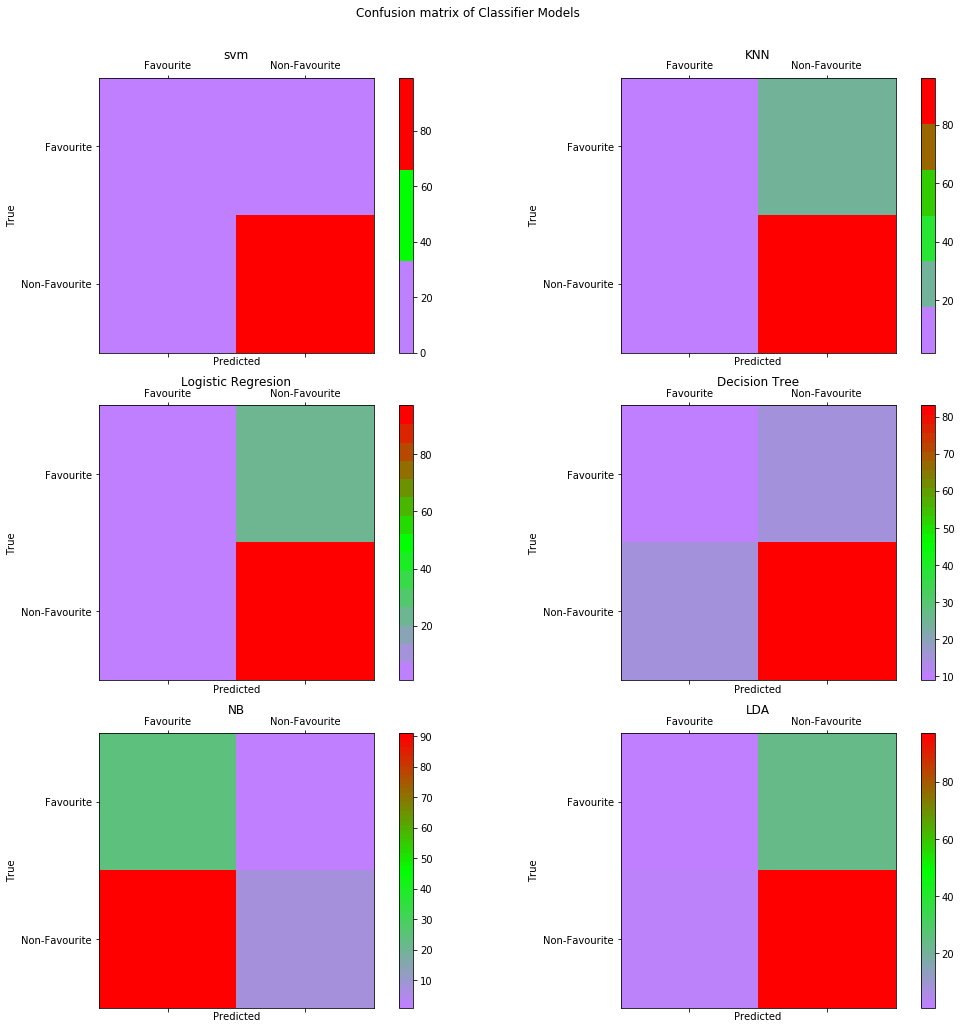

(None, None)

In [41]:
labels = ['Favourite', 'Non-Favourite']
Title='Confusion matrix of Classifier Models'
nrows=3
ncols=2
plot_confusion_matrix(Title,models,y_test,y_pred,labels,nrows,ncols)

In [42]:
#!pip install graphviz --user
#!pip install pydotplus --user

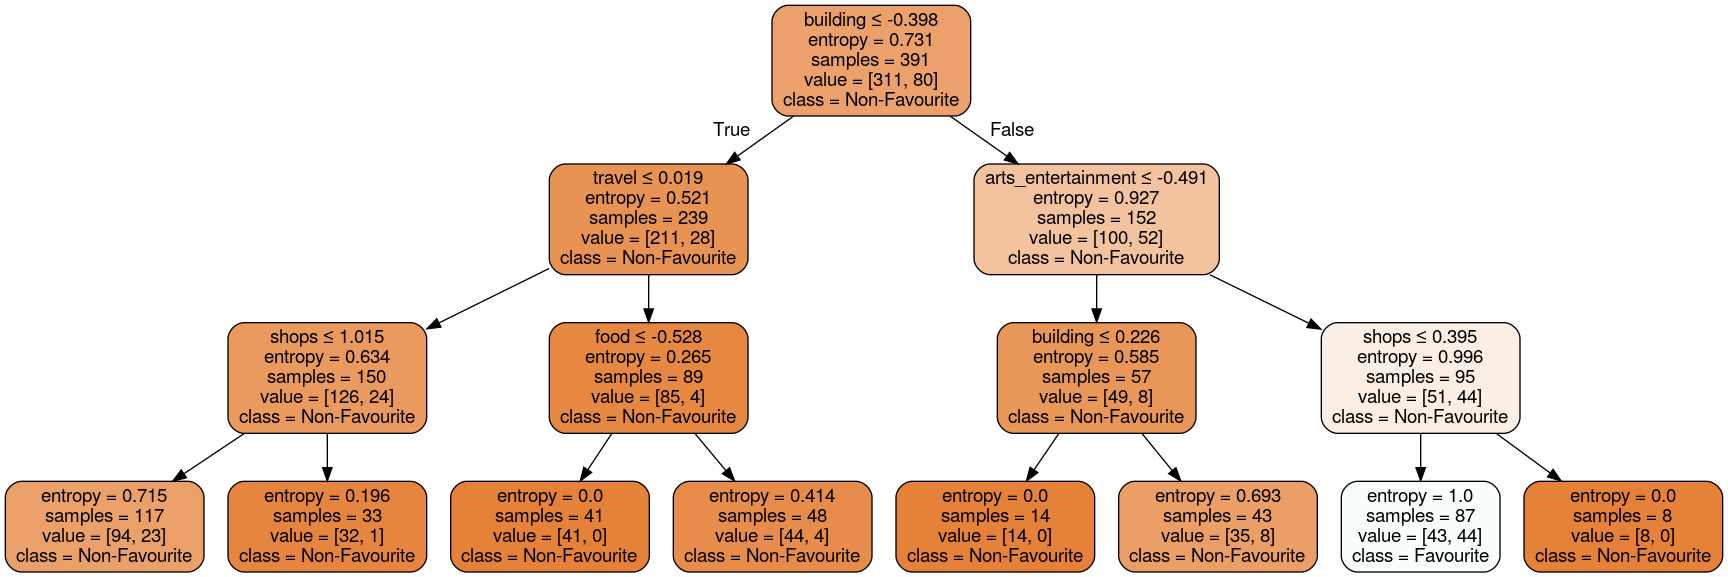

In [43]:
#Visualizing Decision Trees
#! pip install six --user
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf[3], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = columns,class_names=['Non-Favourite','Favourite'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('London_classifiers.png')
Image(graph.create_png())

In [44]:
import tensorflow as tf

In [45]:
from keras.layers import Dense

Using TensorFlow backend.


In [46]:
from keras.models import Sequential

In [47]:
tf.keras.backend.set_floatx('float64')

Deep Learning with one hidden layer 

In [48]:
#model
model=Sequential()
model.add(Dense(5, input_dim=9, activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [49]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [50]:
# fit the keras model on the dataset
history=model.fit(X_train,y_train,epochs=30,batch_size=10,verbose=0,
                  validation_split=testsize)

In [51]:
# evaluate the keras model
results = model.evaluate(X_test,y_test,verbose=2)


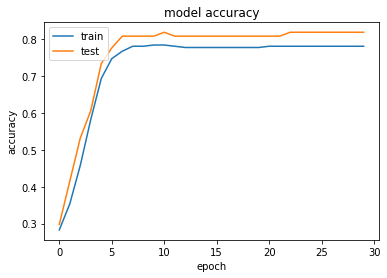

In [52]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

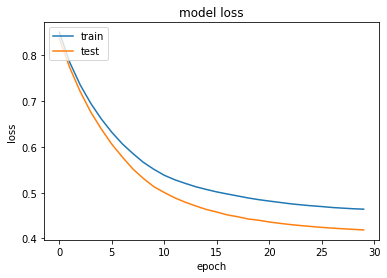

In [53]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [54]:
print('Eval. Test loss; %.2f Eval. Accuracy: %.2f' % (results[0],results[1]*100))
predictions = model.predict(X_test)
#print('predictions:', np.where(predictions>0.5,1,0))

Eval. Test loss; 0.52 Eval. Accuracy: 80.65


In [55]:
testsize=0.24
X=london_data[:,0:9]
sc = StandardScaler()
X = sc.fit_transform(X)
y=london_data[:,9]


In [56]:
 X_train, X_test, y_train, y_test = train_test_split( \
            X, y, test_size=testsize, random_state=1,stratify=y)

Deep Learning with one hidden Layer

In [57]:
#model
ann=Sequential()
ann.add(Dense(12, input_dim=9, activation='relu'))
ann.add(Dense(9,activation='relu'))
ann.add(Dense(1, activation='sigmoid'))


In [58]:
ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [59]:
# fit the keras model on the dataset
history=ann.fit(X,y,epochs=150,batch_size=10,verbose=0,
                  validation_data=(X_test,y_test))

In [60]:
# evaluate the keras model
results = ann.evaluate(X_test,y_test,verbose=2)


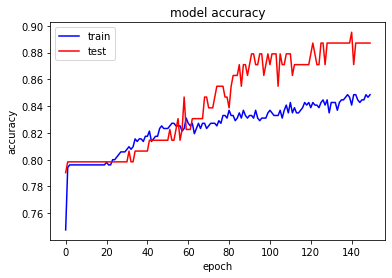

In [61]:
# summarize history for accuracy
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

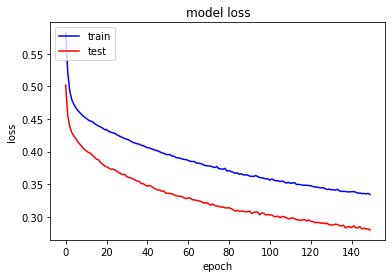

Eval. Test loss; 0.28 Eval. Accuracy: 88.71


In [62]:
# summarize history for loss
plt.plot(history.history['loss'],color='b')
plt.plot(history.history['val_loss'],color='r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print('Eval. Test loss; %.2f Eval. Accuracy: %.2f' % (results[0],results[1]*100))
predictions = model.predict(X_test)


In [63]:
print('Eval. Test loss; %.2f Eval. Accuracy: %.2f' % (results[0],results[1]*100))

Eval. Test loss; 0.28 Eval. Accuracy: 88.71


In [64]:
london_data_index=London_neig_grouped_mean[London_neig_grouped_mean.columns[0]].values.tolist()

In [65]:
type(london_data)

london_data=pd.DataFrame(london_data,columns=London_neig_grouped_mean.columns[1:].to_list())
london_data.index=london_data_index

In [66]:
london_data.to_csv("/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/DATA/london_data_t_index.csv")

In [67]:
london_data.head()

,arts_entertainment,building,education,event,food,nightlife,parks_outdoors,shops,travel,Favourite
Abbey Wood,0.0,0.0,0.0,0.0,0.00,0.00,0.50,0.50,0.00,0.0
Acton,0.0,0.0,0.0,0.0,0.20,0.00,0.10,0.30,0.40,1.0
Addington,0.0,0.0,0.0,0.0,0.25,0.00,0.00,0.25,0.50,0.0
Addiscombe,0.0,0.0,0.0,0.0,0.50,0.00,0.25,0.25,0.00,0.0
Albany Park,0.0,0.0,0.0,0.0,0.25,0.25,0.00,0.25,0.25,0.0
